In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

from datetime import datetime

pd.set_option("display.max_column", 100)
pd.set_option("display.precision", 15)

# Data Cleaning

In [21]:
crime_df = pd.read_csv("../data/crime_2022.csv")
crime_df

/var/folders/q0/tp61rdx579s1pr09fjqsx_gw0000gn/T/ipykernel_84361/1756663924.py:1: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
0           222076257           619                 NaN   
1           222053099          2670                 NaN   
2           222039411          3201                 NaN   
3           222011090          3201                 NaN   
4           222062685          3201                 NaN   
...               ...           ...                 ...   
73847       232000091          1402                 NaN   
73848       232000002          3831                 NaN   
73849       232000140           619                 NaN   
73850       232000315          3201                 NaN   
73851       232000052          3114                 NaN   

                         OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  \
0                         LARCENY ALL OTHERS       D4            167   
1            HARASSMENT/ CRIMINAL HARASSMENT       A7                  
2                   PROPERTY - LOST/ MISSING      D14            778   
3                   PROPERTY - LOST/ MISSING       B3            465   
4                   PROPERTY - LOST/ MISSING       B3            465   
...                                      ...      ...            ...   
73847                              VANDALISM       A1             66   
73848  M/V - LEAVING SCENE - PROPERTY DAMAGE      C11                  
73849                     LARCENY ALL OTHERS      D14            778   
73850               PROPERTY - LOST/ MISSING       D4            167   
73851                   INVESTIGATE PROPERTY       A1                  

       SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR  UCR_PART  \
0             0  2022-01-01 00:00:00  2022      1    Saturday     0       NaN   
1             0  2022-01-01 00:00:00  2022      1    Saturday     0       NaN   
2             0  2022-01-01 00:00:00  2022      1    Saturday     0       NaN   
3             0  2022-01-01 00:00:00  2022      1    Saturday     0       NaN   
4             0  2022-01-01 00:00:00  2022      1    Saturday     0       NaN   
...         ...                  ...   ...    ...         ...   ...       ...   
73847         0  2022-12-31 23:30:00  2022     12    Saturday    23       NaN   
73848         0  2022-12-31 23:37:00  2022     12    Saturday    23       NaN   
73849         0  2022-12-31 23:45:00  2022     12    Saturday    23       NaN   
73850         0  2022-12-31 23:50:00  2022     12    Saturday    23       NaN   
73851         0  2022-12-31 23:50:00  2022     12    Saturday    23       NaN   

                STREET                 Lat                Long  \
0         HARRISON AVE  42.339541989830138 -71.069408769675434   
1        BENNINGTON ST  42.377246384798163 -71.032597080412799   
2        WASHINGTON ST  42.349056000305062 -71.150498499750228   
3        BLUE HILL AVE  42.284825765804882 -71.091373689388021   
4        BLUE HILL AVE  42.284825765804882 -71.091373689388021   
...                ...                 ...                 ...   
73847       CHARLES ST  42.359790374587753 -71.070782344495413   
73848      COLUMBIA RD  42.319592983346539 -71.062606996342723   
73849    WASHINGTON ST  42.349056000305062 -71.150498499750228   
73850  HARRISON AVENUE                 NaN                 NaN   
73851  MOUNT VERNON ST  42.357878706878985 -71.069679730397326   

                                       Location  
0       (42.33954198983014, -71.06940876967543)  
1        (42.37724638479816, -71.0325970804128)  
2       (42.34905600030506, -71.15049849975023)  
3       (42.28482576580488, -71.09137368938802)  
4       (42.28482576580488, -71.09137368938802)  
...                                         ...  
73847   (42.35979037458775, -71.07078234449541)  
73848   (42.31959298334654, -71.06260699634272)  
73849   (42.34905600030506, -71.15049849975023)  
73850                                       NaN  
73851  (42.357878706878985, -71.06967973039733)  

[73852 rows x 17 columns]

In [22]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73852 entries, 0 to 73851
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   INCIDENT_NUMBER      73852 non-null  object 
 1   OFFENSE_CODE         73852 non-null  int64  
 2   OFFENSE_CODE_GROUP   0 non-null      float64
 3   OFFENSE_DESCRIPTION  73852 non-null  object 
 4   DISTRICT             73681 non-null  object 
 5   REPORTING_AREA       73852 non-null  object 
 6   SHOOTING             73852 non-null  int64  
 7   OCCURRED_ON_DATE     73852 non-null  object 
 8   YEAR                 73852 non-null  int64  
 9   MONTH                73852 non-null  int64  
 10  DAY_OF_WEEK          73852 non-null  object 
 11  HOUR                 73852 non-null  int64  
 12  UCR_PART             0 non-null      float64
 13  STREET               73851 non-null  object 
 14  Lat                  70044 non-null  float64
 15  Long                 70044 non-null 

## Initial observations
1. OFFENSE_CODE_GROUP and UCR_PART are completely null, thus we can drop
2. INCIDENT_NUMBER can be cast into int type (unless some start with a 0)
3. OCCURRED_ON_DATE and other time columns can be cast into datetime

In [23]:
# Drop null and redundant columns
crime_df = crime_df.drop(columns=["OFFENSE_CODE_GROUP", "UCR_PART", "YEAR", "MONTH", "HOUR"])
crime_df["OCCURRED_ON_DATE"] = pd.to_datetime(crime_df["OCCURRED_ON_DATE"])
crime_df

INCIDENT_NUMBER  OFFENSE_CODE                    OFFENSE_DESCRIPTION  \
0           222076257           619                     LARCENY ALL OTHERS   
1           222053099          2670        HARASSMENT/ CRIMINAL HARASSMENT   
2           222039411          3201               PROPERTY - LOST/ MISSING   
3           222011090          3201               PROPERTY - LOST/ MISSING   
4           222062685          3201               PROPERTY - LOST/ MISSING   
...               ...           ...                                    ...   
73847       232000091          1402                              VANDALISM   
73848       232000002          3831  M/V - LEAVING SCENE - PROPERTY DAMAGE   
73849       232000140           619                     LARCENY ALL OTHERS   
73850       232000315          3201               PROPERTY - LOST/ MISSING   
73851       232000052          3114                   INVESTIGATE PROPERTY   

      DISTRICT REPORTING_AREA  SHOOTING    OCCURRED_ON_DATE DAY_OF_WEEK  \
0           D4            167         0 2022-01-01 00:00:00    Saturday   
1           A7                        0 2022-01-01 00:00:00    Saturday   
2          D14            778         0 2022-01-01 00:00:00    Saturday   
3           B3            465         0 2022-01-01 00:00:00    Saturday   
4           B3            465         0 2022-01-01 00:00:00    Saturday   
...        ...            ...       ...                 ...         ...   
73847       A1             66         0 2022-12-31 23:30:00    Saturday   
73848      C11                        0 2022-12-31 23:37:00    Saturday   
73849      D14            778         0 2022-12-31 23:45:00    Saturday   
73850       D4            167         0 2022-12-31 23:50:00    Saturday   
73851       A1                        0 2022-12-31 23:50:00    Saturday   

                STREET                 Lat                Long  \
0         HARRISON AVE  42.339541989830138 -71.069408769675434   
1        BENNINGTON ST  42.377246384798163 -71.032597080412799   
2        WASHINGTON ST  42.349056000305062 -71.150498499750228   
3        BLUE HILL AVE  42.284825765804882 -71.091373689388021   
4        BLUE HILL AVE  42.284825765804882 -71.091373689388021   
...                ...                 ...                 ...   
73847       CHARLES ST  42.359790374587753 -71.070782344495413   
73848      COLUMBIA RD  42.319592983346539 -71.062606996342723   
73849    WASHINGTON ST  42.349056000305062 -71.150498499750228   
73850  HARRISON AVENUE                 NaN                 NaN   
73851  MOUNT VERNON ST  42.357878706878985 -71.069679730397326   

                                       Location  
0       (42.33954198983014, -71.06940876967543)  
1        (42.37724638479816, -71.0325970804128)  
2       (42.34905600030506, -71.15049849975023)  
3       (42.28482576580488, -71.09137368938802)  
4       (42.28482576580488, -71.09137368938802)  
...                                         ...  
73847   (42.35979037458775, -71.07078234449541)  
73848   (42.31959298334654, -71.06260699634272)  
73849   (42.34905600030506, -71.15049849975023)  
73850                                       NaN  
73851  (42.357878706878985, -71.06967973039733)  

[73852 rows x 12 columns]

In [24]:
crime_df[crime_df["STREET"].isna()]

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_DESCRIPTION DISTRICT  \
27078       222036082          2619  FUGITIVE FROM JUSTICE       A1   

      REPORTING_AREA  SHOOTING    OCCURRED_ON_DATE DAY_OF_WEEK STREET  \
27078                        0 2022-05-20 08:39:00      Friday    NaN   

                      Lat               Long  \
27078  42.353371005930079 -71.05482398397082   

                                      Location  
27078  (42.35337100593008, -71.05482398397082)

From Google Maps this point is between Purchase St and Atlantic Ave, we will fill the value with Atlantic Ave because there are many more records

In [25]:
print(f"# crimes on Purchase St: {len(crime_df[crime_df['STREET'] == 'PURCHASE ST'])}")
print(f"# crimes on Atlantic Ave: {len(crime_df[crime_df['STREET'] == 'ATLANTIC AVE'])}")

# crimes on Purchase St: 7
# crimes on Atlantic Ave: 101


In [26]:
# Fill nan STREET value with ATLANTIC AVE
crime_df.loc[27078, "STREET"] = "ATLANTIC AVE"

In [27]:
# There are no records without STREET or LOCATION
crime_df[(crime_df["STREET"].isna()) & (crime_df["Location"]).isna()]

Empty DataFrame
Columns: [INCIDENT_NUMBER, OFFENSE_CODE, OFFENSE_DESCRIPTION, DISTRICT, REPORTING_AREA, SHOOTING, OCCURRED_ON_DATE, DAY_OF_WEEK, STREET, Lat, Long, Location]
Index: []

In [28]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73852 entries, 0 to 73851
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   INCIDENT_NUMBER      73852 non-null  object        
 1   OFFENSE_CODE         73852 non-null  int64         
 2   OFFENSE_DESCRIPTION  73852 non-null  object        
 3   DISTRICT             73681 non-null  object        
 4   REPORTING_AREA       73852 non-null  object        
 5   SHOOTING             73852 non-null  int64         
 6   OCCURRED_ON_DATE     73852 non-null  datetime64[ns]
 7   DAY_OF_WEEK          73852 non-null  object        
 8   STREET               73852 non-null  object        
 9   Lat                  70044 non-null  float64       
 10  Long                 70044 non-null  float64       
 11  Location             70044 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 6.8+ MB


# Data Visualization
## [Plotting example](https://www.kaggle.com/code/christotk/analyse-crimes-in-boston-with-geopandas-and-folium)

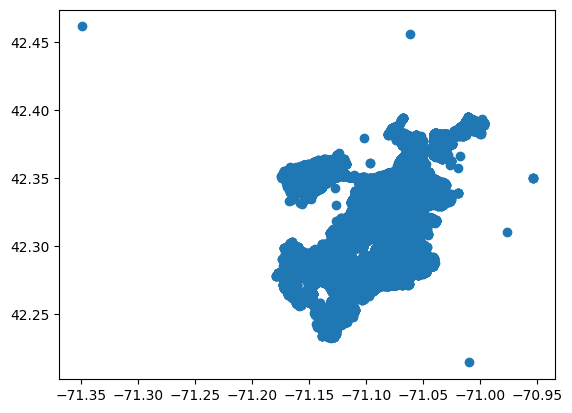

In [29]:
plt.scatter(x=crime_df["Long"], y=crime_df["Lat"])
plt.show()

In [30]:
boston_map = gpd.read_file("../data/boston.geojson")
boston_map.head()

name                       created_at  \
0        Roslindale 2013-02-19 04:40:34.216000+00:00   
1     Jamaica Plain 2013-02-19 04:40:34.216000+00:00   
2  Leather District 2013-02-19 04:40:34.216000+00:00   
3           Roxbury 2013-02-19 04:40:34.216000+00:00   
4            Fenway 2013-02-19 04:40:34.216000+00:00   

                        updated_at  cartodb_id  \
0 2013-02-19 04:40:34.466000+00:00           1   
1 2013-02-19 04:40:34.466000+00:00           2   
2 2013-02-19 04:40:34.466000+00:00           6   
3 2013-02-19 04:40:34.466000+00:00           9   
4 2013-02-19 04:40:34.466000+00:00          17   

                                            geometry  
0  MULTIPOLYGON (((-71.12593 42.27200, -71.12575 ...  
1  MULTIPOLYGON (((-71.09831 42.32630, -71.09858 ...  
2  MULTIPOLYGON (((-71.05838 42.34982, -71.05877 ...  
3  MULTIPOLYGON (((-71.08314 42.34153, -71.08303 ...  
4  MULTIPOLYGON (((-71.11011 42.35207, -71.10986 ...

In [31]:
import geoplot
import geoplot.crs as gcrs
import folium

# ax = geoplot.polyplot(
#     boston_map,
#     projection=gcrs.AlbersEqualArea(),
#     edgecolor='darkgrey',
#     facecolor='lightgrey',
#     linewidth=.3,
#     figsize=(12, 8)
# )

# plt.show()


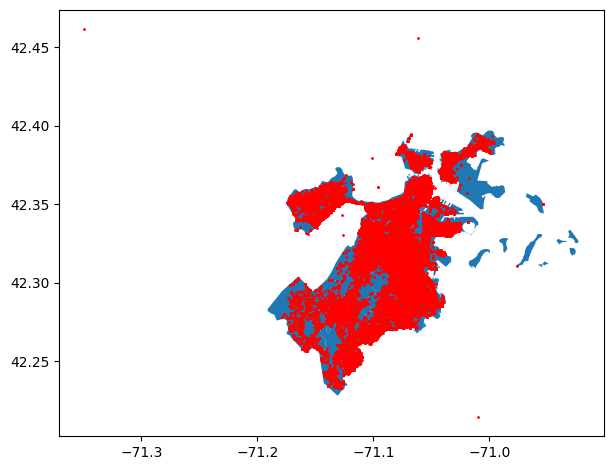

In [32]:
ax = boston_map.plot()
plt.scatter(x=crime_df["Long"], y=crime_df["Lat"], c='r', s=1)
plt.tight_layout()

In [33]:
# ax = boston_map.plot()
# sns.scatterplot(data=crime_df, x="Long", y="Lat", c="r", s=1)
# plt.tight_layout()

In [39]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = crime_df['Long'],
        lat = crime_df['Lat'],
        # text = crime_df['Location'],
        text = crime_df.index,
        mode = 'markers',
        # marker_color = df['cnt'],
        ))

fig.update_layout(
        title = 'Boston crimes<br>(Hover for coordinates)',
        geo_scope='usa',
    )
fig.update_traces(marker=dict(size=3))
fig.update_geos(fitbounds="locations")
fig.show()

# Points to remove (out of city bounds)
* 42.46141002105424, -71.34946994725333
* 42.455780035435204, -71.06171996541265
* 42.35024510706628, -70.95372636457485
* 42.31067200182541, -70.97636698636428
* 42.214409961698884, -71.00938995466853
* 42.379410013439774, -71.10142996988547
* 42.360839973724595, -71.095980043713
* 42.34278998174402, -71.12682995878038
* 42.330420020186644, -71.12603996978002


In [35]:
# Create new lat long columns in crime_df to drop points outside Boston
import re

def extract_lat(location):
    if type(location) == float:
        return location
    lat_lon = re.findall("-?\d+\.?\d+", location)
    return float(lat_lon[0])

def extract_long(location):
    if type(location) == float:
        return location
    lat_lon = re.findall("-?\d+\.?\d+", location)
    return float(lat_lon[1])


print(extract_lat(str((42.330420020186644, -71.12603996978002))))
print(extract_long(str((42.330420020186644, -71.12603996978002))))

42.330420020186644
-71.12603996978002


In [36]:
# points_outside_bos = [
#     (42.46141, -71.34947),
#     (42.45578, -71.06172),
#     (42.35025, -70.95373),
#     (42.31067, -70.97637),
#     (42.21441, -71.00939),
#     (42.37941, -71.10143),
#     (42.36084, -71.09598),
#     (42.34279, -71.12683),
#     (42.33042, -71.12604),
# ]

points_outside_bos = [
    (42.46141002105424, -71.34946994725333),
    (42.455780035435204, -71.06171996541265),
    (42.35024510706628, -70.95372636457485),
    (42.31067200182541, -70.97636698636428),
    (42.214409961698884, -71.00938995466853),
    (42.379410013439774, -71.10142996988547),
    (42.360839973724595, -71.095980043713),
    (42.34278998174402, -71.12682995878038),
    (42.330420020186644, -71.12603996978002),
]

lats = [pair[0] for pair in points_outside_bos]
longs = [pair[1] for pair in points_outside_bos]

crime_df[(crime_df["Lat"].round(5).isin(lats)) & (crime_df["Long"].round(5).isin(longs))]
# crime_df[(crime_df["Lat"].round(5).isin(lats))]
# crime_df[(crime_df["Long"].isin(longs))]

Empty DataFrame
Columns: [INCIDENT_NUMBER, OFFENSE_CODE, OFFENSE_DESCRIPTION, DISTRICT, REPORTING_AREA, SHOOTING, OCCURRED_ON_DATE, DAY_OF_WEEK, STREET, Lat, Long, Location]
Index: []

In [37]:
crime_df["Location"].apply(extract_lat)

0        42.339541989830138
1        42.377246384798163
2        42.349056000305062
3        42.284825765804882
4        42.284825765804882
                ...        
73847    42.359790374587753
73848    42.319592983346539
73849    42.349056000305062
73850                   NaN
73851    42.357878706878985
Name: Location, Length: 73852, dtype: float64

In [38]:
crime_df["Lat"].round(5)

0        42.339540000000000
1        42.377249999999997
2        42.349060000000001
3        42.284829999999999
4        42.284829999999999
                ...        
73847    42.359789999999997
73848    42.319589999999998
73849    42.349060000000001
73850                   NaN
73851    42.357880000000002
Name: Lat, Length: 73852, dtype: float64